# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import uproot
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

training_variables = util.training_variables
columns = util.all_relevant_variables

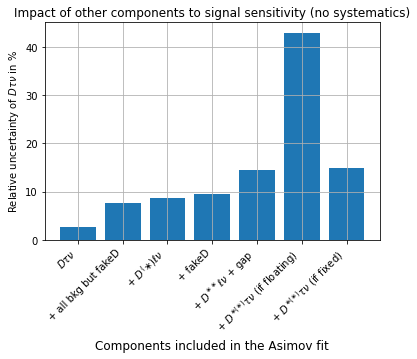

In [14]:
# Sample Data
x_categories = [r'$D\tau\nu$', '+ all bkg but fakeD', r'+ $D^(\ast)\ell\nu$', '+ fakeD',
                r'+ $D^{\ast\ast}\ell\nu$ + gap', r'+ $D^{\ast(\ast)}\tau\nu$ (if floating)',
                r'+ $D^{\ast(\ast)}\tau\nu$ (if fixed)']
y_values = [2.74, 7.64, 8.66, 9.58, 14.5, 43, 15]

# Create the bar plot
# plt.figure(figsize=(10, 6))  # Adjust width and height as needed
plt.bar(x_categories, y_values)

# Add labels and title (optional)
plt.xlabel('Components included in the Asimov fit', fontsize=12)
plt.ylabel(r'Relative uncertainty of $D\tau\nu$ in %')
plt.title('Impact of other components to signal sensitivity (no systematics)')

# Display the plot
plt.xticks(rotation=45, ha='right') # Rotate labels 45 degrees, adjust horizontal alignment
plt.grid()
plt.show()


In [ ]:
# 4S Data vs MC

cut = '(B0_roeMbc_my_mask>5) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1) & (B0_dr<0.1)' # & (__experiment__<20)

# Load data files
MC_4S = uproot.concatenate(['../../Samples/MC16rd/e_channel/4S_deimos_2/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

data_4S = uproot.concatenate(['../../Samples/Data/e_channel/proc16_4S_deimos_2.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

df_mc_4S = pd.DataFrame(MC_4S)
df_data_4S = pd.DataFrame(data_4S)

lgb_tight = 'sig_prob>0.6 and fakeD_prob<0.06 and continuum_prob<0.05 and combinatorial_prob<0.2'
lgb_loose = 'sig_prob>0.6 and fakeD_prob<0.5 and continuum_prob<0.5 and combinatorial_prob<0.5'
lgb_comb = 'fakeD_prob<0.1 and continuum_prob<0.1 and combinatorial_prob>0.7'
lgb_none = 'ell_p>0'

for df in [df_mc_4S,df_data_4S,]: #df_data_4S,
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [3]:
df_mc_4S_loose = util.apply_mva_bcs(df_mc_4S, training_variables, lgb_loose, library='lgbm',model='multiclass')
df_data_4S_loose = util.apply_mva_bcs(df_data_4S, training_variables, lgb_loose, library='lgbm',model='multiclass')

In [5]:
df_mc_4S_comb = util.apply_mva_bcs(df_mc_4S, training_variables, lgb_comb, library='lgbm',model='multiclass')
df_data_4S_comb = util.apply_mva_bcs(df_data_4S, training_variables, lgb_comb, library='lgbm',model='multiclass')

In [6]:
# with uproot.recreate("../../Samples/MC16rd/e_channel/lgb_loose_BDT1.root") as file:
#     file["B0"] = df_mc_4S_loose
# with uproot.recreate("../../Samples/Data/e_channel/proc16_4S_lgb_loose_BDT1.root") as file:
#     file["B0"] = df_data_4S_loose

# with uproot.recreate("../../Samples/MC16rd/e_channel/lgb_comb_BDT1.root") as file:
#     file["B0"] = df_mc_4S_comb
# with uproot.recreate("../../Samples/Data/e_channel/proc16_4S_lgb_comb_BDT1.root") as file:
#     file["B0"] = df_data_4S_comb

In [6]:
# D mass signal region
samples_generic = util.classify_mc_dict(df_mc_4S_loose, 'e', template=False)
# samples_sig = util.classify_mc_dict(df_mc_sig_lgb.query('1.855<D_M<1.885'), 'e', template=False)
mpl=util.mpl(samples_generic)
# mpl_sig = util.mpl(samples_sig)
for name, df in samples_generic.items():
    print(name, len(df))

bkg_fakeD 525016
bkg_TDFl 4016
bkg_fakeTracks 11240
bkg_continuum 41996
bkg_combinatorial 56262
bkg_singleBbkg 37063
bkg_other_TDTl 0
$D\tau\nu$ 14707
$D^\ast\tau\nu$ 8830
$D\ell\nu$ 249703
$D^\ast\ell\nu$ 182114
$D^{\ast\ast}\tau\nu$ 5879
$D^{\ast\ast}\ell\nu$_narrow 63132
$D^{\ast\ast}\ell\nu$_broad 44896
$D\ell\nu$_gap_pi 12739
$D\ell\nu$_gap_eta 10659
bkg_other_signal 0


In [ ]:
# fakeD = samples_generic['bkg_fakeD'].sample(n=300000).copy()

# comb = samples_generic['bkg_combinatorial'].sample(n=300000).copy()

# fakeD['target']=1
# fakeD['weight']=1
# comb['target']=2
# comb['weight']=1
# with uproot.recreate("../../BDTs/train_fakes.root") as file:
#     file["B0"] = pd.concat([fakeD, comb])

In [2]:
# 4S Data vs MC

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1) & (B0_dr<0.1)'

# (DstVeto_massDiff_0<0.135 or 0.145<DstVeto_massDiff_0) and 1.855<D_M<1.885

lgb_tight = 'sig_prob>0.6 and fakeD_prob<0.06 and continuum_prob<0.05 and combinatorial_prob<0.2'
lgb_loose = 'sig_prob>0.6 and fakeD_prob<0.5 and continuum_prob<0.5 and combinatorial_prob<0.5'
lgb_comb = 'fakeD_prob<0.1 and continuum_prob<0.1 and combinatorial_prob>0.7'

# Load data files
MC_4S_loose = uproot.concatenate(['../../Samples/MC16rd/e_channel/lgb_loose_*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

# MC_sig = uproot.concatenate(['../../Samples/MC15ri/e_channel/sig_quaxo_e_1/*.root:B0'],
#                           library="np",
#                           cut = cut,
#                           filter_branch=lambda branch: branch.name in columns)

df_mc_4S_loose_1 = pd.DataFrame(MC_4S_loose)
df_mc_4S_tight = df_mc_4S_loose_1.query(lgb_tight)
# df_mc_sig = pd.DataFrame(MC_sig)

In [3]:
# D mass signal region
samples_generic = util.classify_mc_dict(df_mc_4S_tight, 'e', template=False)
# samples_sig = util.classify_mc_dict(df_mc_sig_lgb.query('1.855<D_M<1.885'), 'e', template=False)
mpl=util.mpl(samples_generic)
# mpl_sig = util.mpl(samples_sig)
for name, df in samples_generic.items():
    print(name, len(df))

bkg_fakeD 127880
bkg_TDFl 2601
bkg_fakeTracks 4987
bkg_continuum 19371
bkg_combinatorial 36293
bkg_singleBbkg 27853
bkg_other_TDTl 0
$D\tau\nu$ 13972
$D^\ast\tau\nu$ 7784
$D\ell\nu$ 226526
$D^\ast\ell\nu$ 152080
$D^{\ast\ast}\tau\nu$ 4742
$D^{\ast\ast}\ell\nu$_narrow 49968
$D^{\ast\ast}\ell\nu$_broad 36813
$D\ell\nu$_gap_pi 9493
$D\ell\nu$_gap_eta 8280
bkg_other_signal 0


In [37]:
# D mass signal region
samples_generic = util.classify_mc_dict(df_mc_4S_loose.query(f'1.855<D_M<1.885 and {lgb_tight}'), 'e', template=False)
# samples_sig = util.classify_mc_dict(df_mc_sig_lgb.query('1.855<D_M<1.885'), 'e', template=False)
mpl=util.mpl(samples_generic)
# mpl_sig = util.mpl(samples_sig)
for name, df in samples_generic.items():
    print(name, len(df))

bkg_fakeD 50884
bkg_TDFl 2073
bkg_fakeTracks 2533
bkg_continuum 17431
bkg_combinatorial 26890
bkg_singleBbkg 19940
bkg_other_TDTl 0
$D\tau\nu$ 9325
$D^\ast\tau\nu$ 5356
$D\ell\nu$ 158243
$D^\ast\ell\nu$ 106858
$D^{\ast\ast}\tau\nu$ 3336
$D^{\ast\ast}\ell\nu$_narrow 34650
$D^{\ast\ast}\ell\nu$_broad 25562
$D\ell\nu$_gap_pi 6491
$D\ell\nu$_gap_eta 5654
bkg_other_signal 0


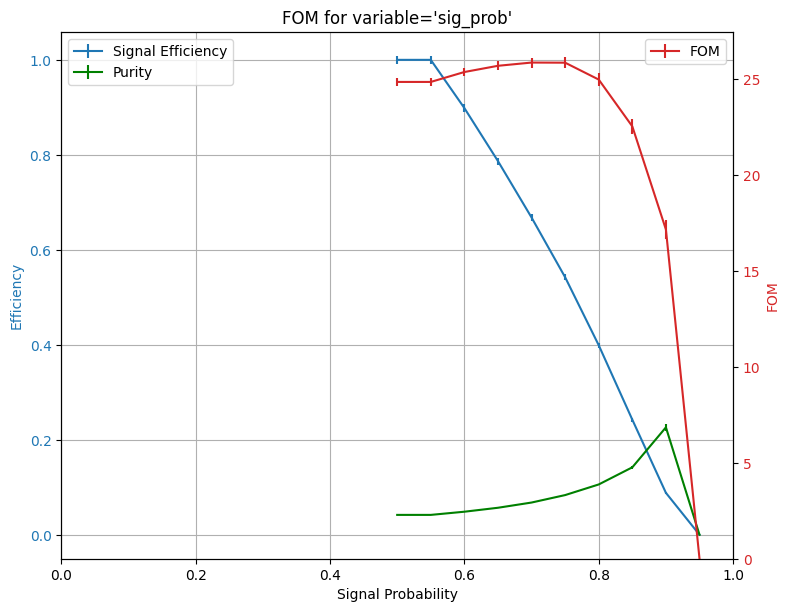

In [11]:
# lgbm
tests = np.linspace(0.5,1,11)
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'],bkgModes=['bkg_fakeD','bkg_TDFl','bkg_fakeTracks',
                                                'bkg_continuum','bkg_combinatorial','bkg_singleBbkg'],
            variable='sig_prob', bins=tests)

# sig_prob>0.6 and fakeD_prob < 0.2, continumm_prob, comb_prob

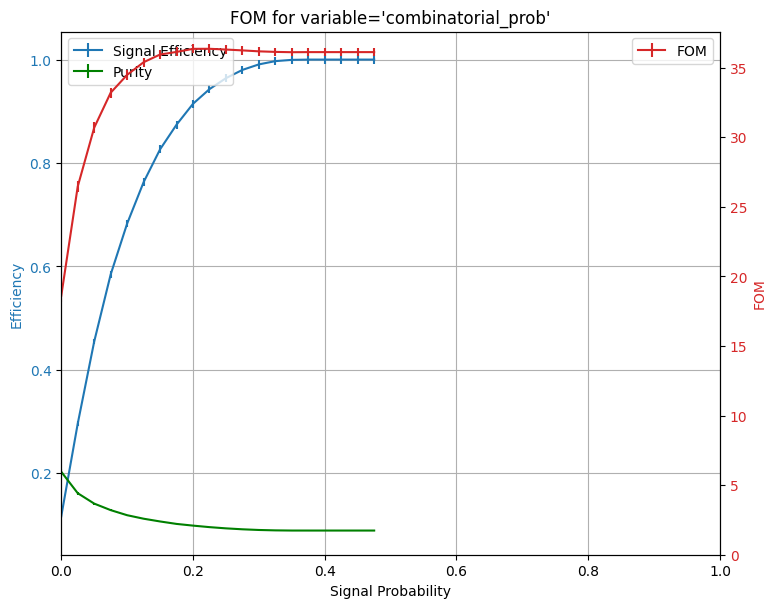

In [30]:
# lightgbm
tests = np.linspace(0,0.5,21)
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'],bkgModes=['bkg_TDFl','bkg_fakeTracks',
                                                'bkg_continuum','bkg_combinatorial','bkg_singleBbkg'],
            variable='combinatorial_prob', bins=tests, cut='sig_prob>0.6 and fakeD_prob<0.1 and continuum_prob<0.1',reverse_selection=True)

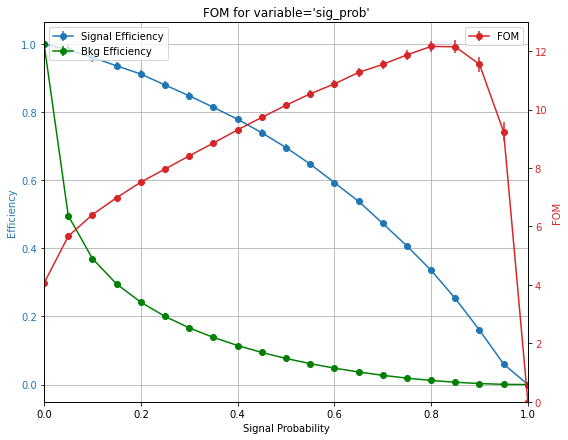

In [19]:
# lgbm
tests = np.linspace(0,1,21)
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'],bkgModes=['bkg_fakeD','bkg_TDFl','bkg_fakeTracks',
                                                'bkg_continuum','bkg_combinatorial','bkg_singleBbkg'],
            variable='sig_prob', test_points=tests)

# sig_prob>0.6 and fakeD_prob < 0.2, continumm_prob, comb_prob

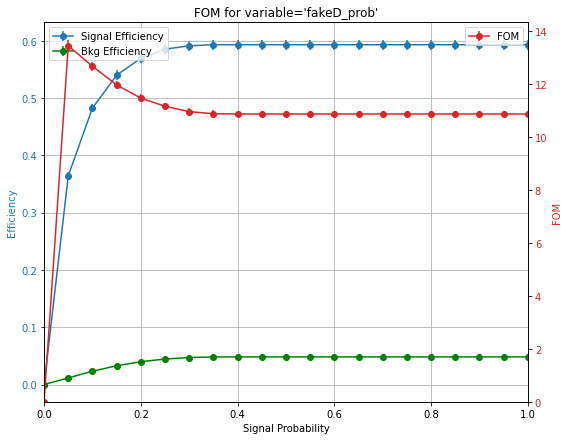

In [20]:
# lightgbm
tests = np.linspace(0,1,21)
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'],bkgModes=['bkg_fakeD','bkg_TDFl','bkg_fakeTracks',
                                                'bkg_continuum','bkg_combinatorial','bkg_singleBbkg'],
            variable='fakeD_prob', test_points=tests, cut='sig_prob>0.6',reverse=True)

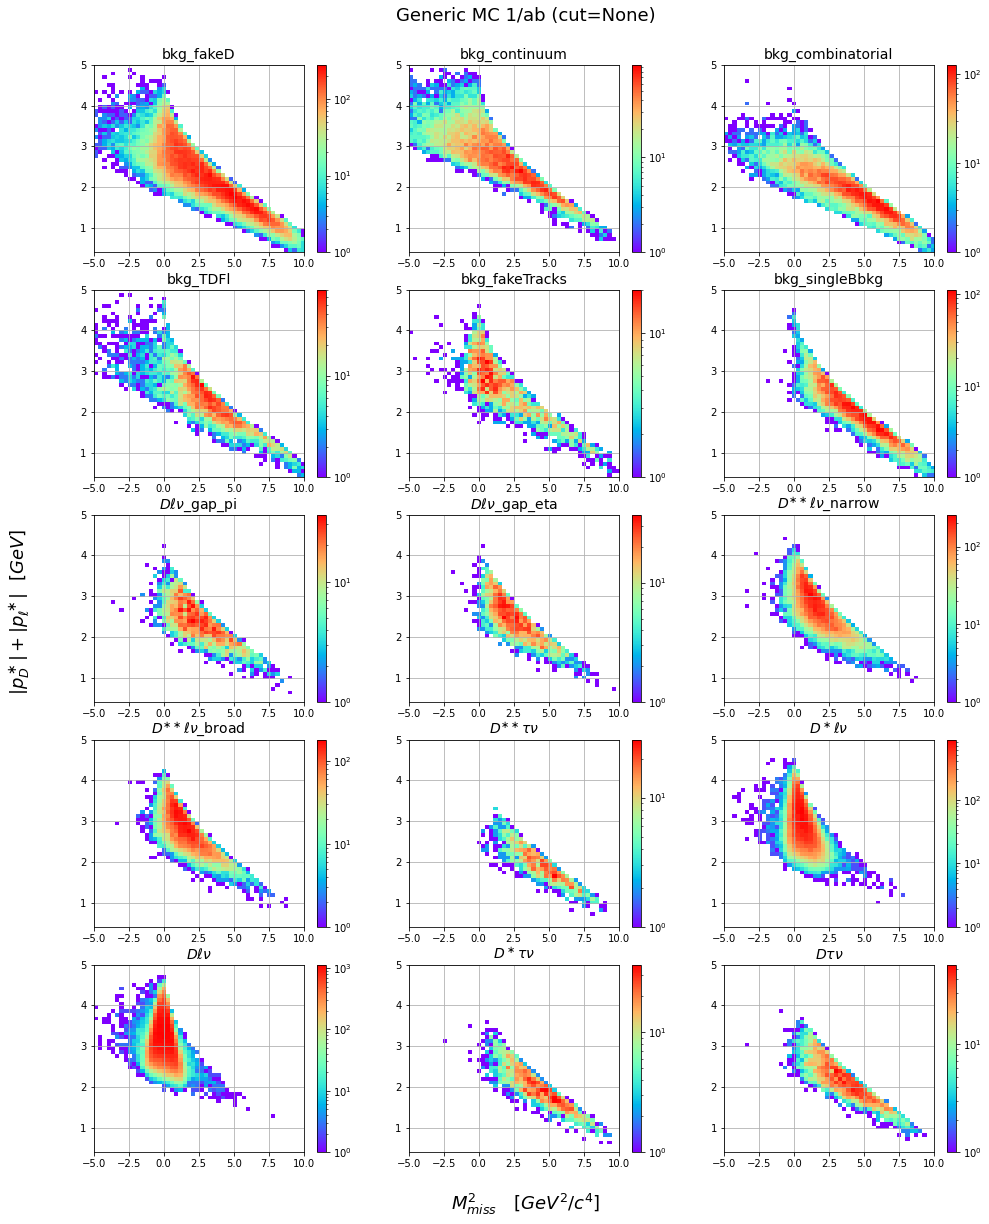

In [9]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.4
end = 5
num_bins = 50

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -5
end = 10
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)

mpl.plot_all_2Dhist(bin_list=[MM2_bins,p_D_l_bins], mask=None,title='Generic MC 1/ab')

mpl.plot_all_2Dhist(bin_list=[MM2_bins,p_D_l_bins],cut='1.855<D_M<1.885',title='Generic MC 1/ab',mask=None)

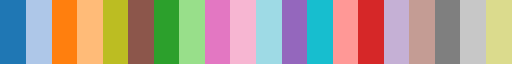

In [10]:
util.my_cmap

# SIG distribution at M_D signal region

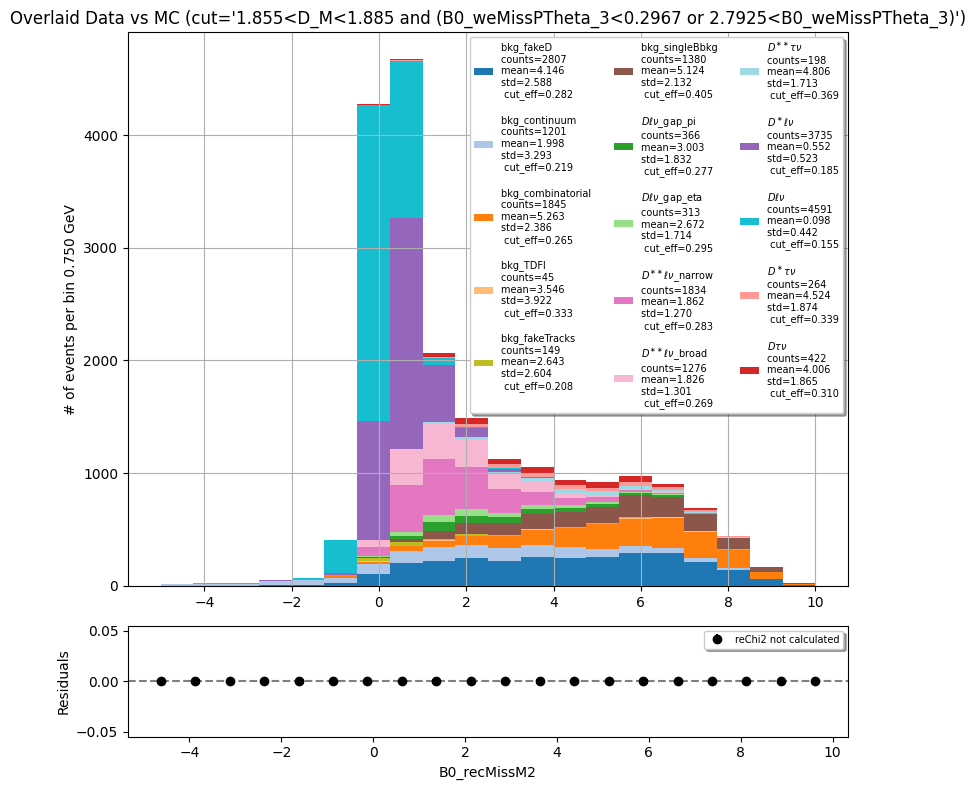

In [28]:
b1 = np.linspace(-5,10,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_recMissM2',bins=b1,cut='1.855<D_M<1.885 and (B0_weMissPTheta_3<0.2967 or 2.7925<B0_weMissPTheta_3)',density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

In [ ]:
b1 = np.linspace(-5,10,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS_weMissM2_4',bins=b1,cut='1.855<D_M<1.885',density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

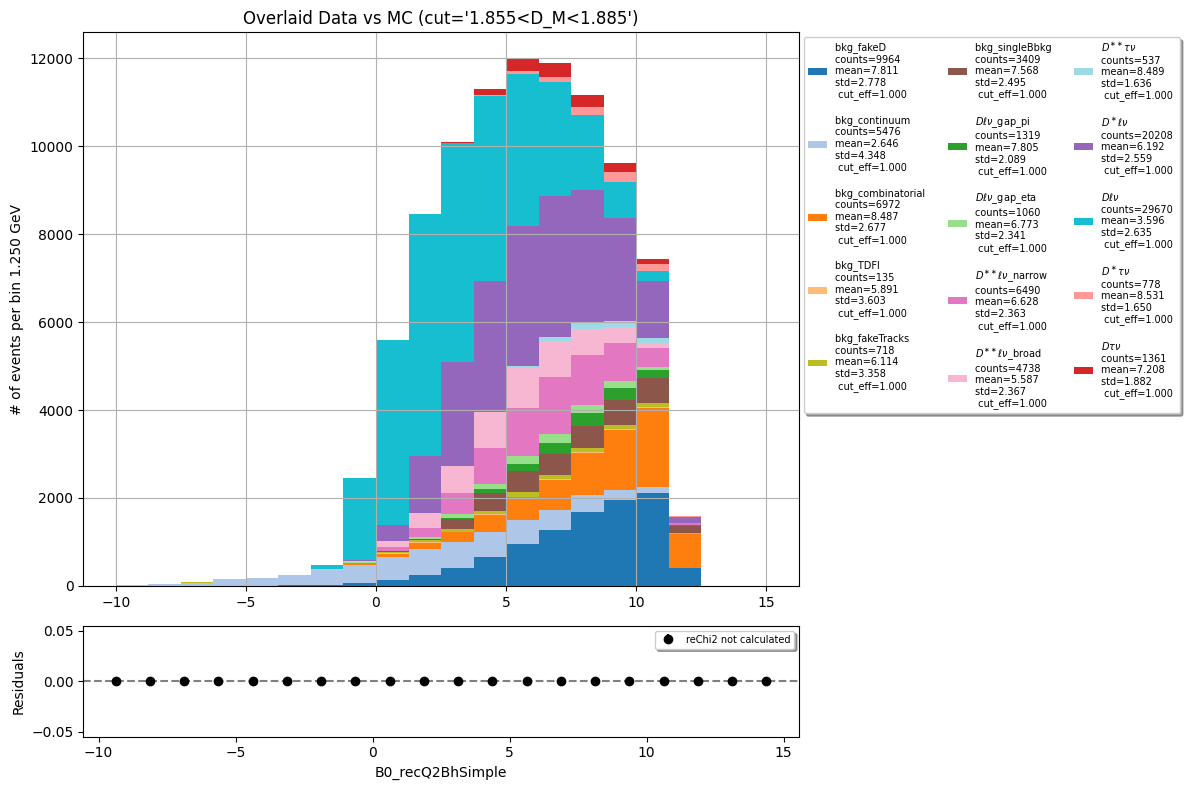

In [19]:
b1 = np.linspace(-10,15,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_recQ2BhSimple',bins=b1,cut='1.855<D_M<1.885',density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

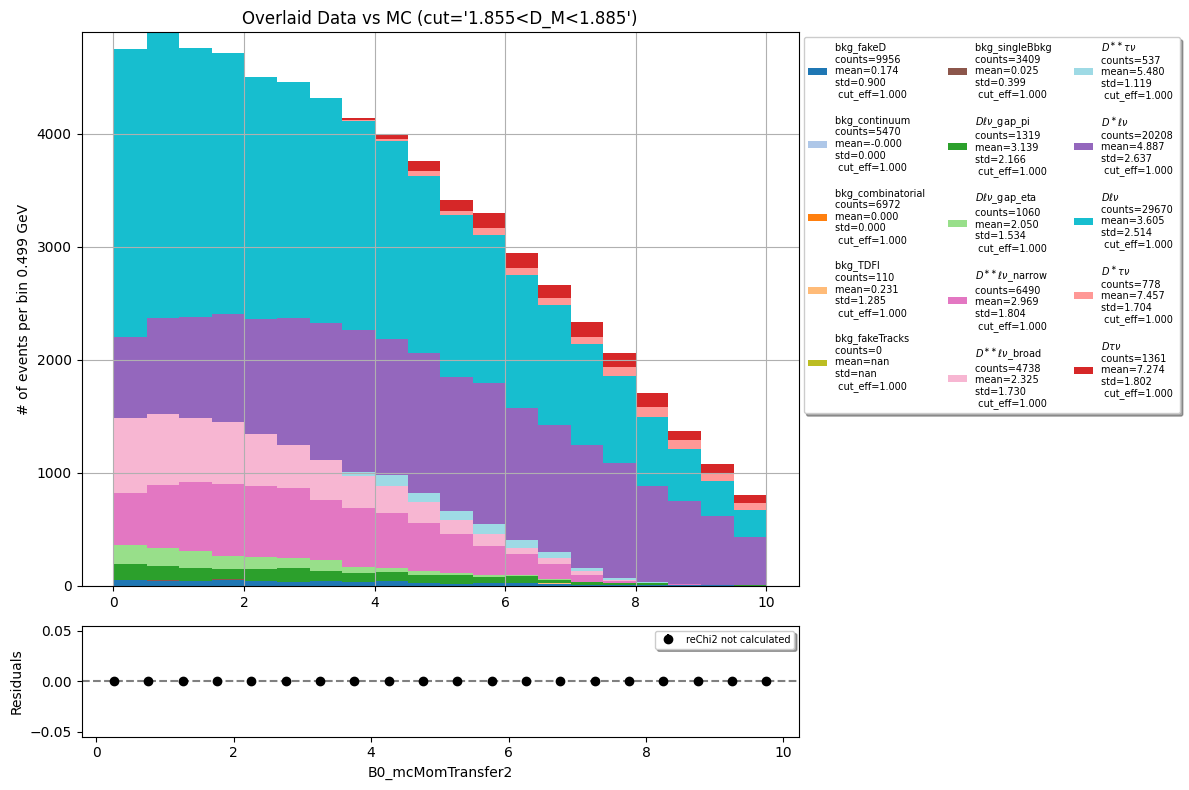

In [18]:
b1 = np.linspace(0.01,10,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_mcMomTransfer2',bins=b1,cut='1.855<D_M<1.885',density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

In [ ]:
b1 = np.linspace(1.79,1.95,81)
mpl.plot_mc_1d_overlaid(variable='D_M',bins=b1,mask=[],
                        cut='D_mcErrors==512 and ell_mcErrors!=512',
                        show_only=['bkg_fakeTracks'],density=False)

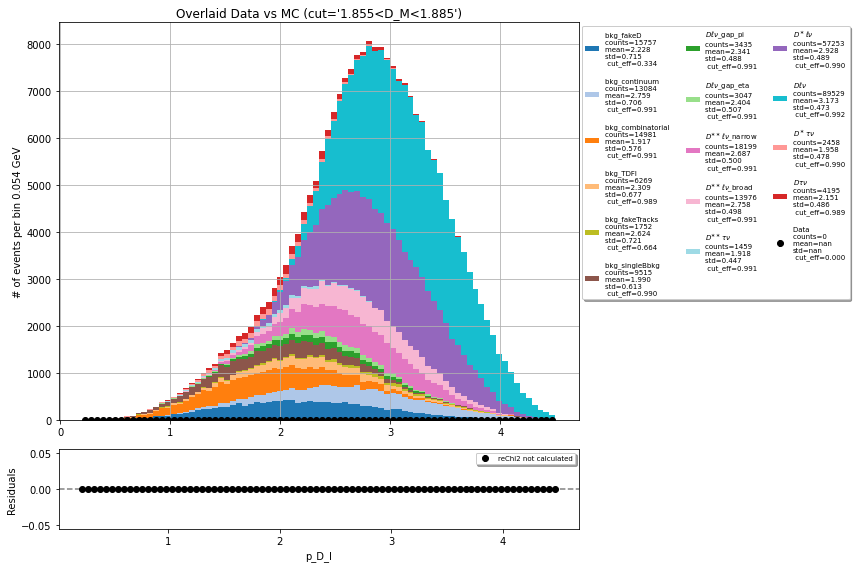

In [14]:
b1 = np.linspace(0.2,4.5,81)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='p_D_l',bins=b1,cut='1.855<D_M<1.885',scale=[1,187/200],density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

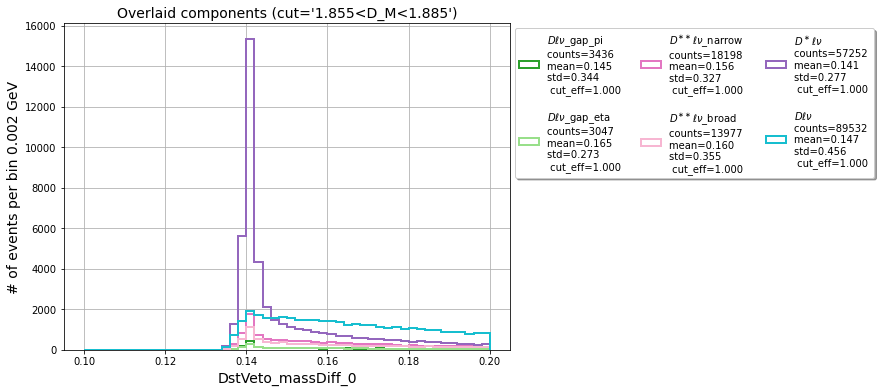

In [5]:
# pi0 eff50_1, photon tight cut
b1 = np.linspace(0.1,0.2,51)
mpl.plot_mc_1d_overlaid(variable='DstVeto_massDiff_0',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='norm',density=False)

In [7]:
# eff50_1 photon tight cut
veto_D = len(samples_generic[r'$D\ell\nu$'].query('0.135<DstVeto_massDiff_0<0.145'))
veto_Dst = len(samples_generic[r'$D^\ast\ell\nu$'].query('0.135<DstVeto_massDiff_0<0.145'))
print('veto D', veto_D, veto_D / 89532)
print('veto D*', veto_Dst, veto_Dst / 57252)

veto D 6711 0.07495644015547513
veto D* 27908 0.4874589533990079


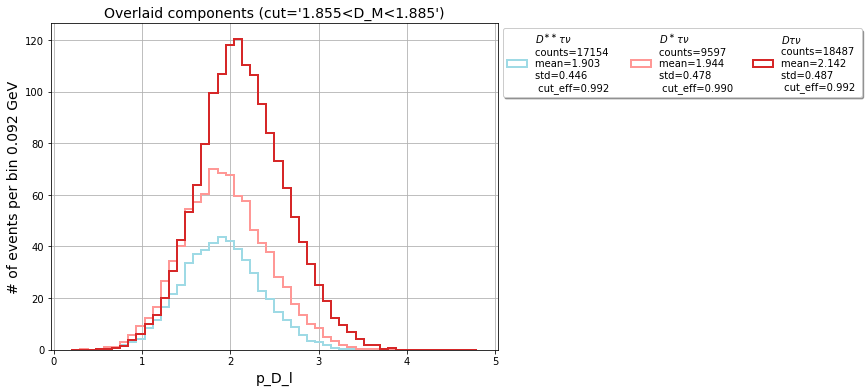

In [6]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',show_only='sig',density=False,
                        weights={r'$D\tau\nu$': 0.36 * 4195/18487, 
                                 r'$D^\ast\tau\nu$': 0.36 * 2458/9597, 
                                 r'$D^{\ast\ast}\tau\nu$': 0.36 * 1459/17154,})

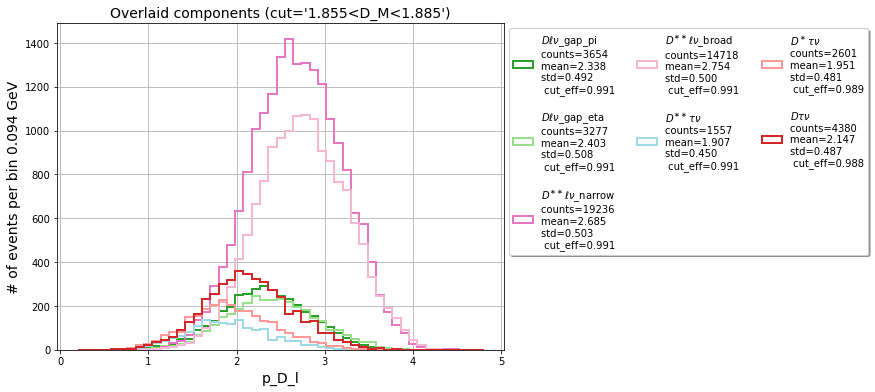

In [8]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

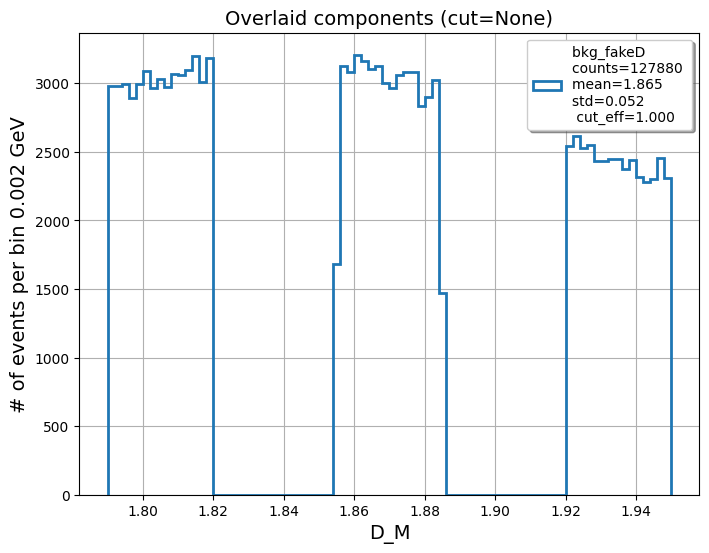

In [6]:
b1 = np.linspace(1.79,1.95,81)
mpl.plot_mc_1d_overlaid(variable='D_M',bins=b1,cut=None,mask=[],
                        show_only=['bkg_fakeD'],density=False)

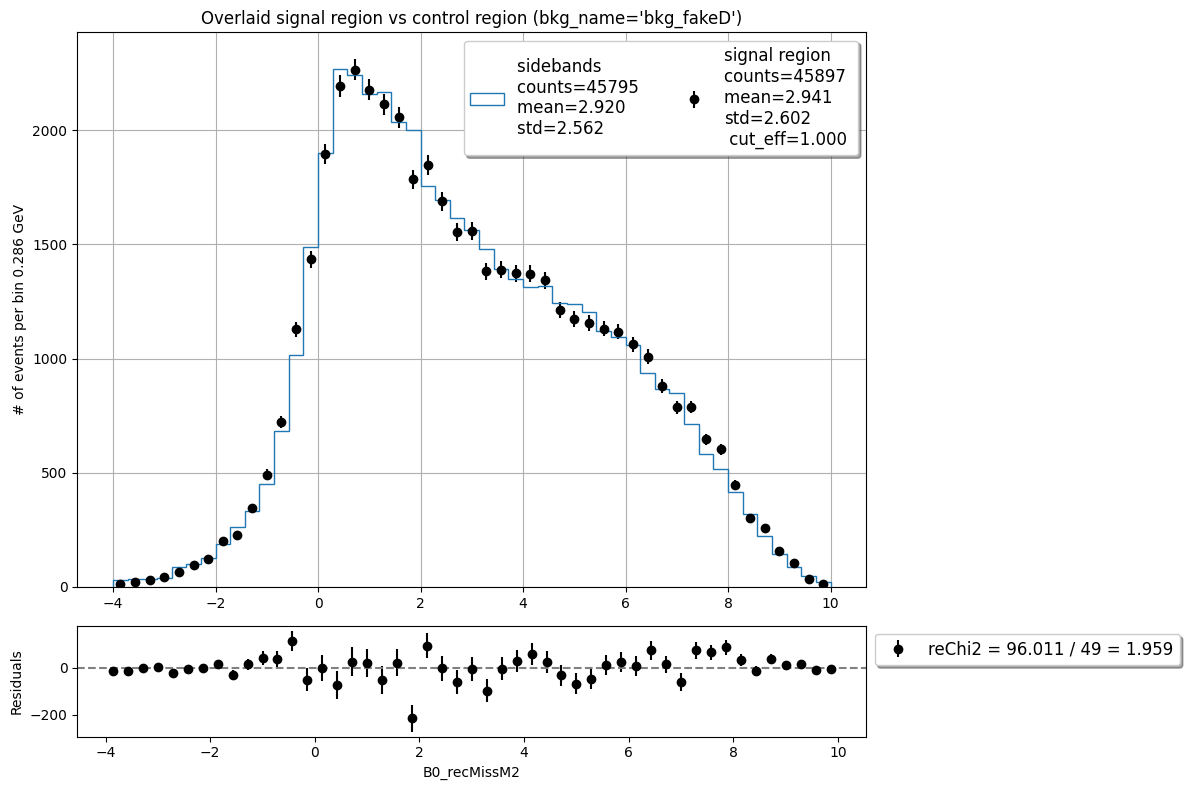

In [30]:
# compare control vs signal regions MC
b1 = np.linspace(-4,10,50)
weights = {'left sideband': 0.35,
           'signal region': 1,
           'right sideband': 0.65}

mpl.plot_mc_sig_control(variable='B0_recMissM2',bins=b1,figsize=(12,8),
                        bkg_name='bkg_fakeD',cut=None, merge_sidebands=True,
                        samples_sig=None, sideband_leak=False,
                        weights=weights, correction=False,mask=[])

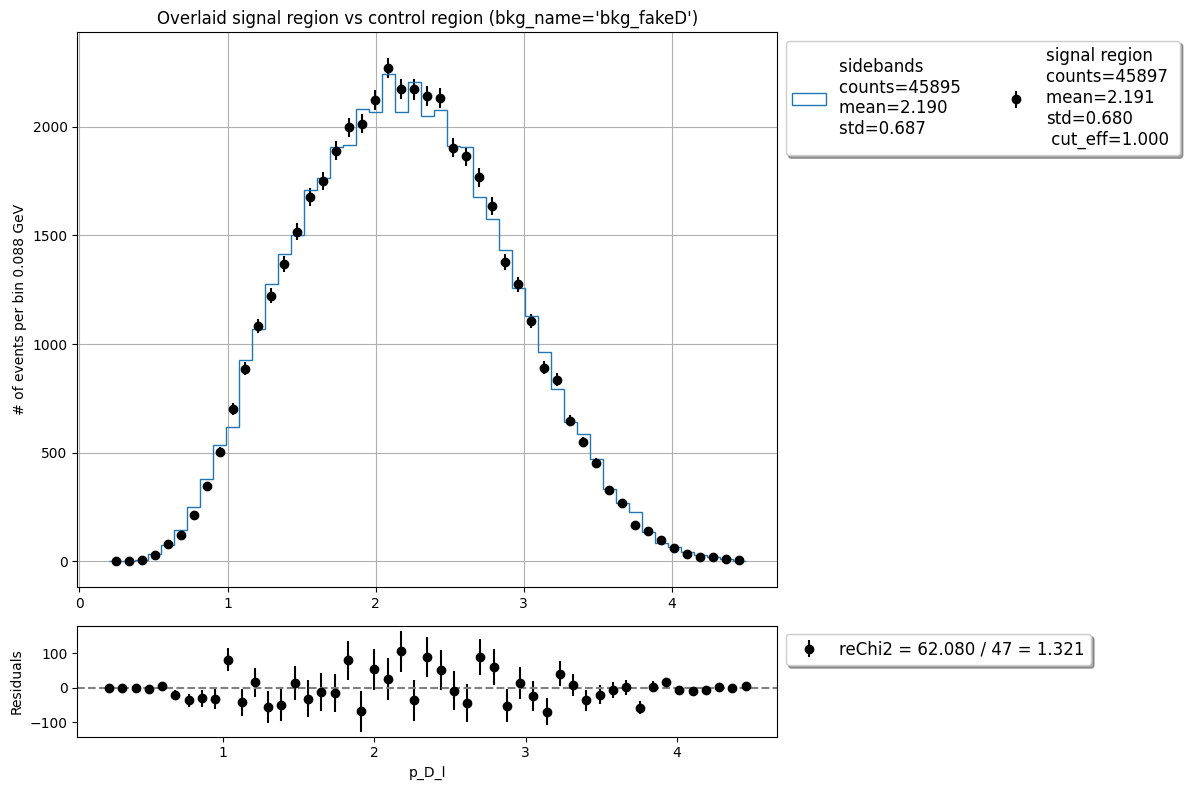

In [31]:
# compare control vs signal regions MC
b1 = np.linspace(0.2,4.5,50)
weights = {'left sideband': 0.35,
           'signal region': 1,
           'right sideband': 0.65}

mpl.plot_mc_sig_control(variable='p_D_l',bins=b1,figsize=(12,8),
                        bkg_name='bkg_fakeD',cut=None, merge_sidebands=True,
                        samples_sig=None, sideband_leak=False,
                        weights=weights, correction=False,mask=[])

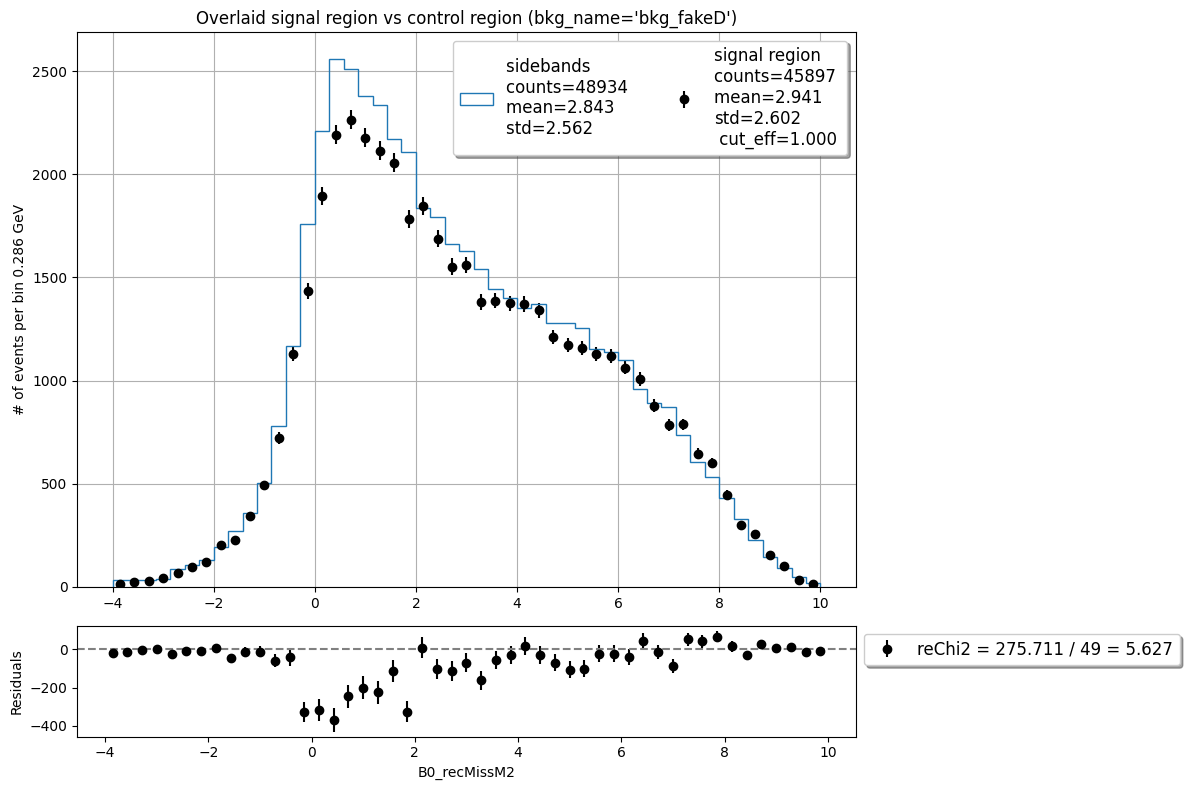

In [7]:
# compare control vs signal regions MC
b1 = np.linspace(-4,10,50)
weights = {'left sideband': 0.35,
           'signal region': 1,
           'right sideband': 0.65}

mpl.plot_mc_sig_control(variable='B0_recMissM2',bins=b1,figsize=(12,8),
                        bkg_name='bkg_fakeD',cut=None, merge_sidebands=True,
                        samples_sig=None, full_sideband=True,
                        weights=weights, correction=False,mask=[])

# BKG composition

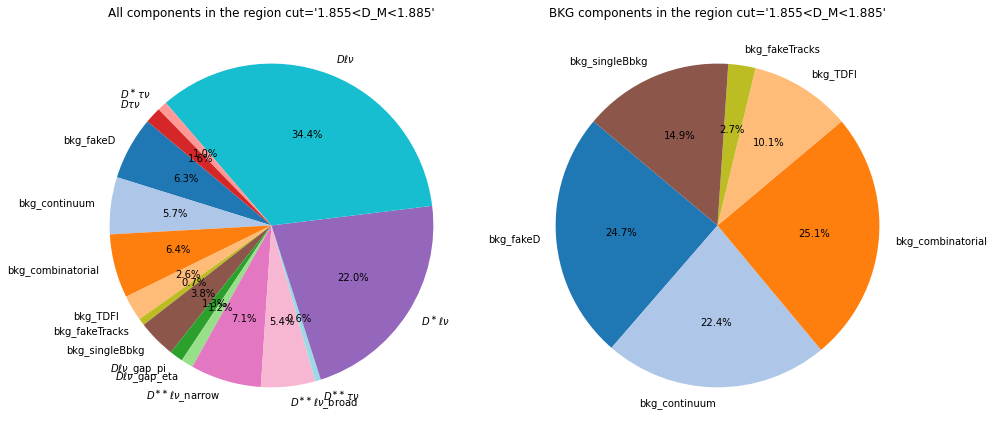

In [20]:
mpl.plot_pie()

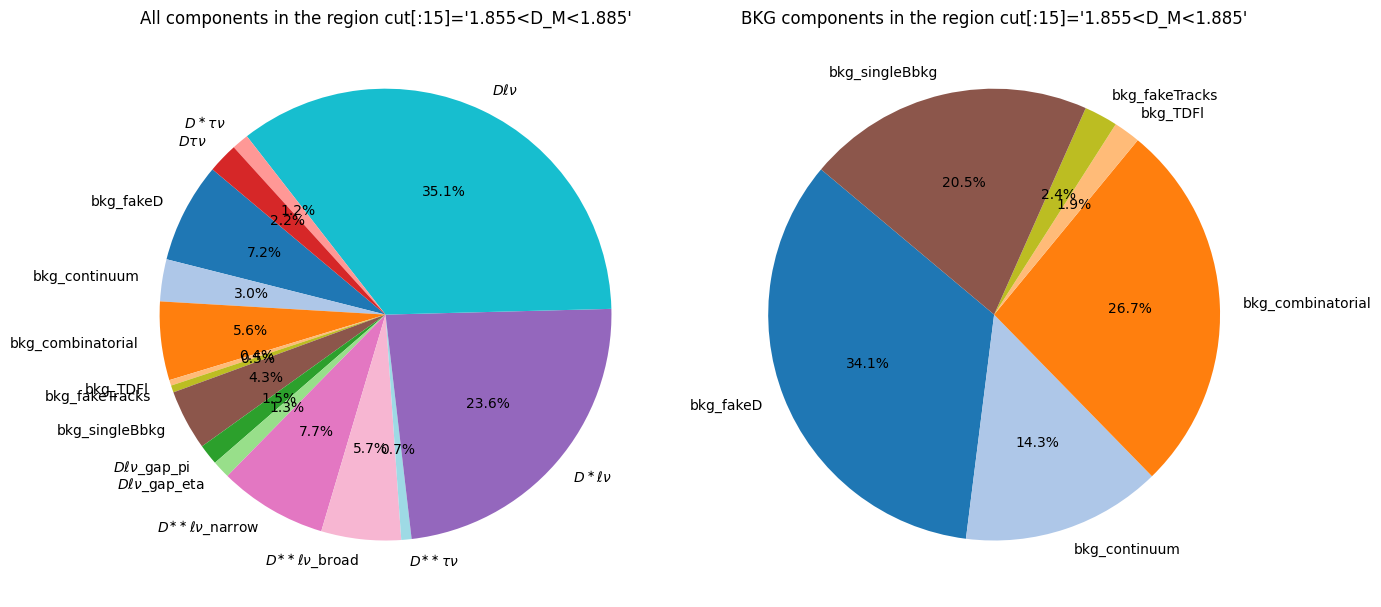

In [9]:
mpl.plot_pie(cut=f'1.855<D_M<1.885 and {lgb_tight}')

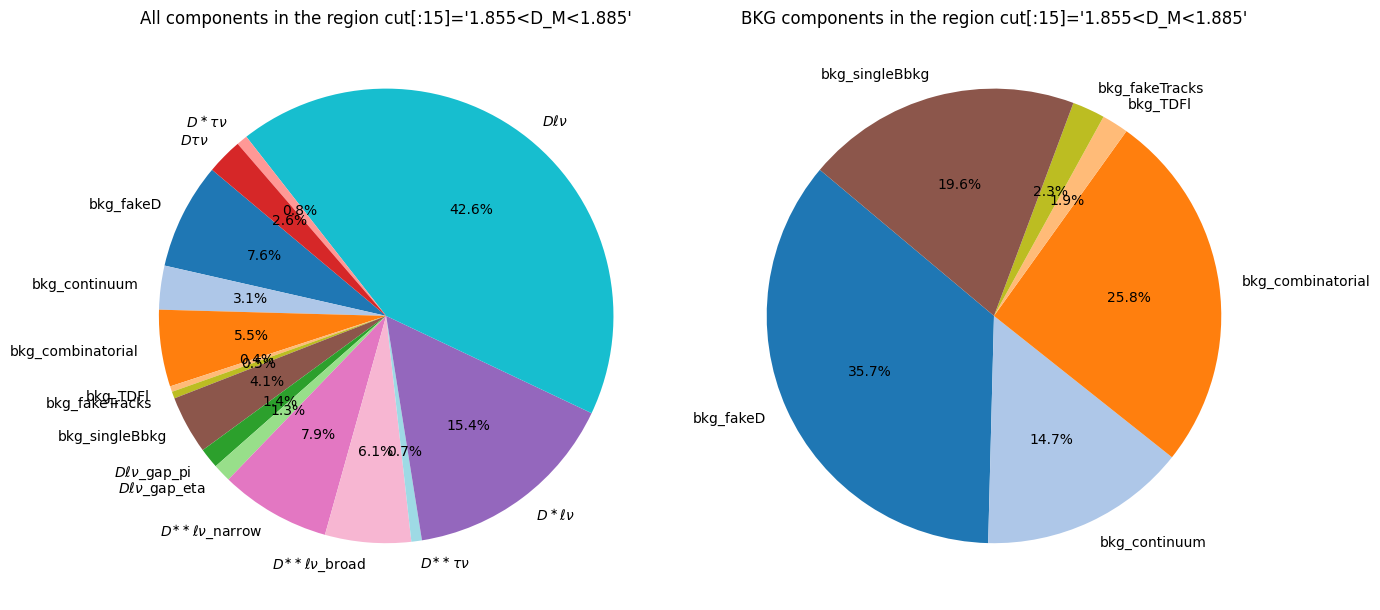

In [4]:
mpl.plot_pie(cut=f'1.855<D_M<1.885 and {lgb_tight} and (DstVeto_massDiff_0<0.135 or 0.145<DstVeto_massDiff_0)')

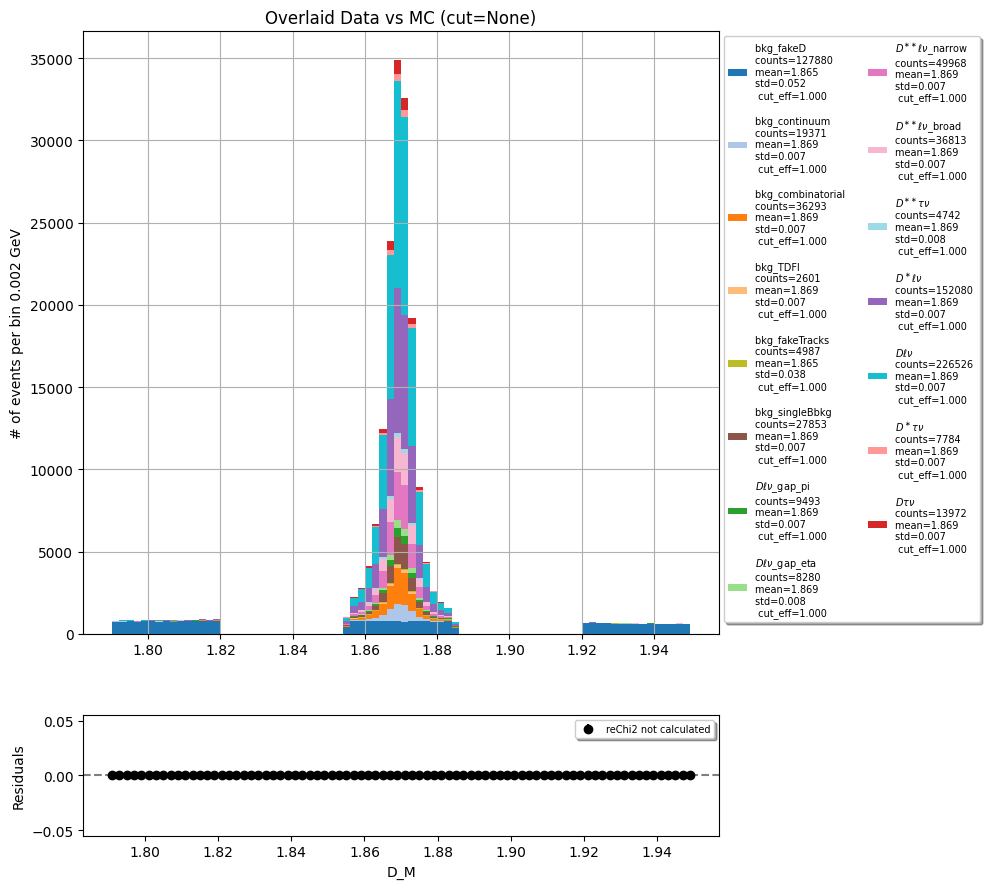

In [28]:
# BDT signal region
b1 = np.linspace(1.79,1.95,81)
weights={'all_mc':0.25}
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut=None,legend_nc=2,legend_fs=7,
                                                      weights=weights,correction=False,
                                                      mask=[],figsize=(10,9),ratio=False)

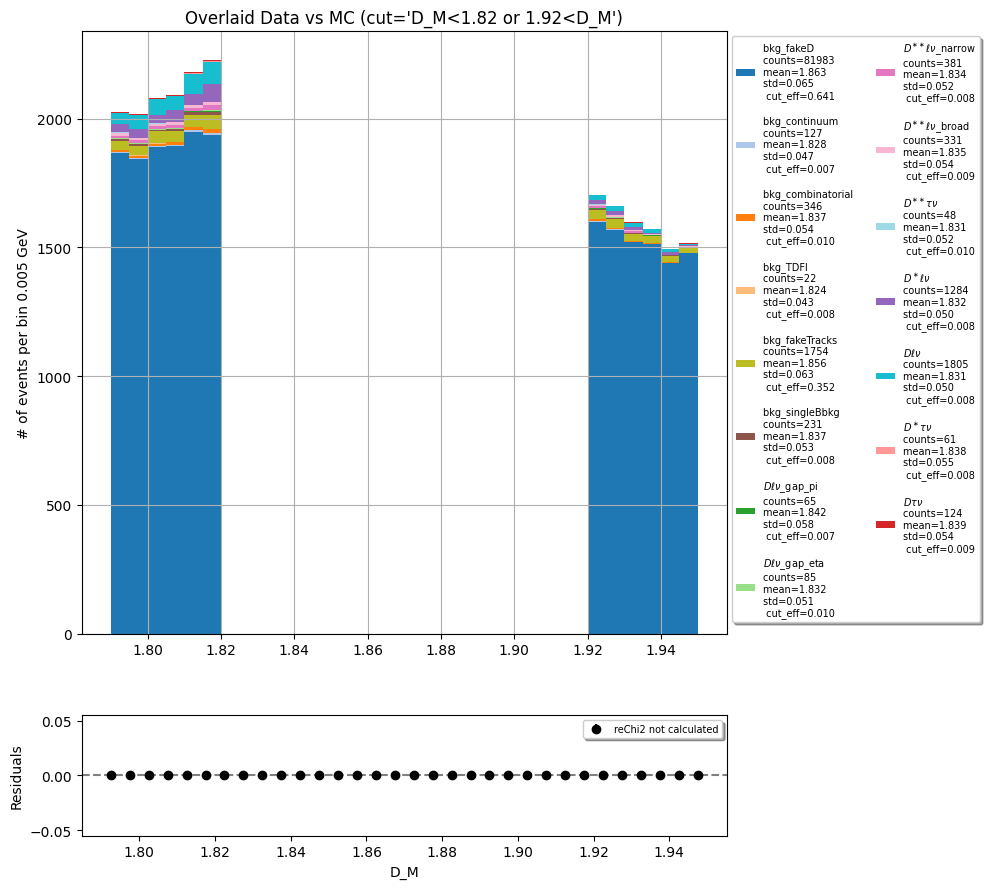

In [22]:
# BDT signal region
b1 = np.linspace(1.79,1.95,33)
weights={'all_mc':0.25}
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut='D_M<1.82 or 1.92<D_M',legend_nc=2,legend_fs=7,
                                                      weights=weights,correction=False,
                                                      mask=[''],figsize=(10,9),ratio=False)

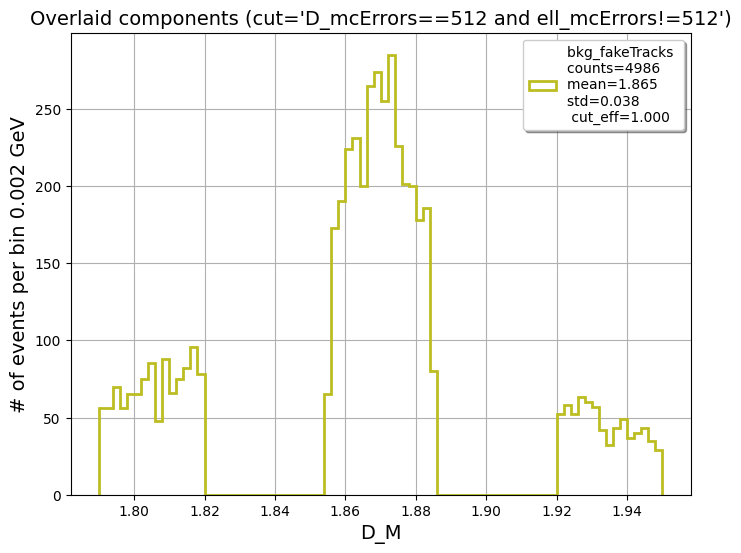

In [26]:
b1 = np.linspace(1.79,1.95,81)
mpl.plot_mc_1d_overlaid(variable='D_M',bins=b1,mask=[],
                        cut='D_mcErrors==512 and ell_mcErrors!=512',
                        show_only=['bkg_fakeTracks'],density=False)

In [40]:
# calculate the sideband leak correction
cut_left = '1.79<D_M<1.82'
cut_sig = '1.855<D_M<1.885'
cut_right = '1.92<D_M<1.95'
left_leak = 0
left_total = 0
right_leak = 0
right_total = 0
for name, df in samples_generic.items():
    left_total += len(df.query(cut_left) )
    right_total += len(df.query(cut_right) )
    if name in [r'$D\ell\nu$', r'$D^\ast\ell\nu$']:
        print(name, 'left:', len(df.query(cut_left)), 'right:', len(df.query(cut_right)))
        left_leak += len(df.query(cut_left))
        right_leak += len(df.query(cut_right) )

print( (left_total - left_leak)/left_total, (right_total - right_leak)/right_total)
correction = np.array([0.95]*15+[1]*50+[0.984]*15)

$D\ell\nu$ left: 1465 right: 340
$D^\ast\ell\nu$ left: 1030 right: 254
0.9505656713756414 0.984440486169321


In [42]:
fitter = util.fit_Dmass(x_edges=b1, hist=mc_hist_all*correction, poly_only=True)
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml

initial parameters= [ 3.628000e+02  1.870000e+00  2.000000e-02  1.813772e+05 -1.307100e+03
  3.158200e+03]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 39 (χ²/ndof = 1.5)         │              Nfcn = 150              │
│ EDM = 1.32e-07 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     0     │     4     │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.870   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  20.0e-3  │  0.2e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │  56.7e3   │   0.4e3   │            │            │         │         │       │
│ 4 │ x4   │  -1.5e3   │   0.4e3   │            │            │         │         │       │
│ 5 │ x5   │   3.6e3   │   1.1e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────┐
│    │       x0       x1       x2       x3       x4       x5 │
├────┼───────────────────────────────────────────────────────┤
│ x0 │        0        0        0        0        0        0 │
│ x1 │        0        0        0        0        0        0 │
│ x2 │        0        0        0        0        0        0 │
│ x3 │        0        0        0 1.57e+05       -0       -0 │
│ x4 │        0        0        0       -0 1.99e+05  -0.48e6 │
│ x5 │        0        0        0       -0  -0.48e6 1.17e+06 │
└────┴───────────────────────────────────────────────────────┘

In [30]:
# fit with no correction
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ml)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ml)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ml)

mm2_left * yield_sig/yield_left * 1.04 /2 + mm2_right * yield_sig/yield_right *1.04 /2
mm2_left * yield_sig/yield_left * 1.08 /2 + mm2_right * yield_sig/yield_right /2

Yields from 1.79 to 1.82 = 12507.080 ± 114.744
Yields from 1.855 to 1.885 = 11027.595 ± 75.689
Yields from 1.92 to 1.95 = 9548.111 ± 97.462


In [59]:
# MC truth of fakeD + fakeTracks
cut_left = '1.79<D_M<1.82 and fakeD_prob<0.06'
cut_sig = '1.855<D_M<1.885 and fakeD_prob<0.06'
cut_right = '1.92<D_M<1.95 and fakeD_prob<0.06'
print('left sideband',len(samples_generic['bkg_fakeD'].query(cut_left))*0.25)
print('sig region',len(samples_generic['bkg_fakeD'].query(cut_sig))*0.25)
print('right sideband',len(samples_generic['bkg_fakeD'].query(cut_right))*0.25)
print()
print('left sideband',(len(samples_generic['bkg_fakeD'].query(cut_left))+len(samples_generic['bkg_fakeTracks'].query(cut_left)))*0.25)
print('sig region',(len(samples_generic['bkg_fakeD'].query(cut_sig))+ 50*15 )*0.25)
print('right sideband',(len(samples_generic['bkg_fakeD'].query(cut_right))+len(samples_generic['bkg_fakeTracks'].query(cut_right)))*0.25)

left sideband 11378.0
sig region 11474.25
right sideband 9117.75

left sideband 11643.25
sig region 11661.75
right sideband 9291.0


In [44]:
print(9291/11643, 9548/12507, 9392/11886)

0.7979902087090955 0.7634124890061565 0.7901733131415111


In [43]:
# fit sideband with correction
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ml)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ml)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ml)

Yields from 1.79 to 1.82 = 11886.528 ± 111.865
Yields from 1.855 to 1.885 = 10639.586 ± 74.328
Yields from 1.92 to 1.95 = 9392.644 ± 96.689


# Signal MC

In [14]:
# 4S Data vs MC

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1)'

# Load data files
MC_sig = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_sig_quaxo_e_1/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

df_mc_sig = pd.DataFrame(MC_sig)

In [15]:
lgb_tight = 'sig_prob==largest_prob and sig_prob>0.6 and fakeD_prob<0.05'
ag_tight = 'sig_prob==largest_prob and sig_prob>0.8 and fakeD_prob<0.05'
MVA_all = 'D_M>0'

df_mc_sig.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df_mc_sig.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

df_mc_sig_lgb = util.apply_mva_bcs(df_mc_sig, training_variables, lgb_tight, library='lgbm')

In [16]:
samples=util.get_dataframe_samples_new(df_mc_sig_lgb, 'e', template=False)
mpl=util.mpl(samples)
for name, df in samples.items():
    print(name, len(df))

bkg_fakeD 21978
bkg_TDFl 1998
bkg_fakeTracks 1456
bkg_continuum 0
bkg_combinatorial 13430
bkg_singleBbkg 2793
bkg_other_TDTl 0
$D\tau\nu$ 19505
$D^\ast\tau\nu$ 10179
$D\ell\nu$ 32183
$D^\ast\ell\nu$ 20601
$D^{\ast\ast}\tau\nu$ 18450
$D^{\ast\ast}\ell\nu$_narrow 6048
$D^{\ast\ast}\ell\nu$_broad 4185
$D\ell\nu$_gap_pi 1281
$D\ell\nu$_gap_eta 1458
bkg_other_signal 0
